# Applications of Graph Neural Networks

In [1]:
import os
from copy import deepcopy
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data
from torch_geometric.loader.neighbor_sampler import EdgeIndex
from torch_geometric.utils import to_networkx
from tqdm import tqdm

# Feature Augmentation on Graphs

In [2]:
def draw_graph_from_data(data: Data, node_size: Optional[int] = 1500, seed: Optional[int] = None) -> None:
    G = to_networkx(data, to_undirected=data.is_undirected())
    labels = {node_id: f"ID: {node_id}\n$x_{node_id}$: {node_x.tolist()}" for node_id, node_x in enumerate(data.x)}
    pos = nx.spring_layout(G, seed=seed)
    nx.draw(G, pos=pos, labels=labels, node_size=node_size)

## Asign constant values to nodes

Num. nodes: 6
Num. node features: 1
Num. edges: 14
Is undirected? True


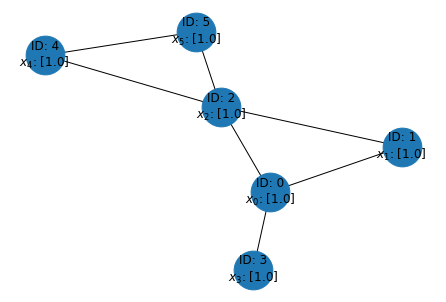

In [3]:
x = torch.ones((6, 1))
edge_index = torch.tensor(
    [[0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 5], [1, 2, 3, 0, 2, 0, 1, 4, 5, 0, 2, 5, 2, 4]], dtype=torch.long
)
data = Data(x=x, edge_index=edge_index)
print(f"Num. nodes: {data.num_nodes}")
print(f"Num. node features: {data.num_node_features}")
print(f"Num. edges: {data.num_edges}")
print(f"Is undirected? {data.is_undirected()}")

draw_graph_from_data(data, seed=42)

## Asign unique IDs to nodes

Num. nodes: 6
Num. node features: 6
Num. edges: 14
Is undirected? True


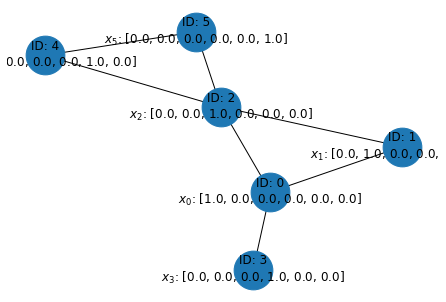

In [4]:
x = torch.eye(6)
edge_index = torch.tensor(
    [[0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 5], [1, 2, 3, 0, 2, 0, 1, 4, 5, 0, 2, 5, 2, 4]], dtype=torch.long
)
data = Data(x=x, edge_index=edge_index)
print(f"Num. nodes: {data.num_nodes}")
print(f"Num. node features: {data.num_node_features}")
print(f"Num. edges: {data.num_edges}")
print(f"Is undirected? {data.is_undirected()}")

draw_graph_from_data(data, seed=42)

# Add Virtual Nodes/Edges

## Add virtual edges

In [5]:
from torch_geometric.utils import dense_to_sparse, to_dense_adj

In [6]:
def draw_bipartite(
    data: Data,
    node1_color: str = "tab:orange",
    node2_color: str = "tab:blue",
    node1_shape: str = "o",
    node2_shape: str = "s",
    set1_name: str = "Authors",
    set2_name: str = "Papers",
    text_size: int = 16,
    font_weight: str = "bold",
) -> None:
    group0_len = (data.x == 0).sum().item()
    group1_len = (data.x == 1).sum().item()
    len_max = max(group0_len, group1_len)
    offset = (group0_len - group1_len) / 2
    bipartite = data.x.flatten().tolist()
    labels = {
        node_id: str(node_id - group0_len + 1) if node_group else chr(node_id + 65)
        for node_id, node_group in enumerate(bipartite)
    }
    pos = {
        node_id: (1 + node_group, group0_len - node_id + node_group * (offset + group0_len - 1))
        for node_id, node_group in enumerate(bipartite)
    }
    node_colors = [node1_color if gr else node2_color for gr in bipartite]
    node_shapes = [node1_shape if gr else node2_shape for gr in bipartite]
    G = to_networkx(data, to_undirected=data.is_undirected())

    nx.draw_networkx_nodes(range(group0_len), pos=pos, node_color=node1_color, node_shape=node1_shape)
    nx.draw_networkx_nodes(
        range(group0_len, group0_len + group1_len), pos=pos, node_color=node2_color, node_shape=node2_shape
    )
    nx.draw_networkx_labels(G, pos=pos, labels=labels)
    nx.draw_networkx_edges(G, pos=pos, width=2)

    plt.text(0.95, len_max + 0.75, set1_name, size=text_size, fontweight=font_weight)
    plt.text(1.95, len_max + 0.75, set2_name, size=text_size, fontweight=font_weight)

    plt.axis("off")

In [7]:
def connect_two_hop_neighbors(data: Data) -> Data:
    data = deepcopy(data)
    A = to_dense_adj(data.edge_index)[0]
    idx = range(len(A))
    A2 = torch.matrix_power(A, 2)
    A2[idx, idx] = 0.0
    data.edge_index = dense_to_sparse(A + A2)[0]
    return data

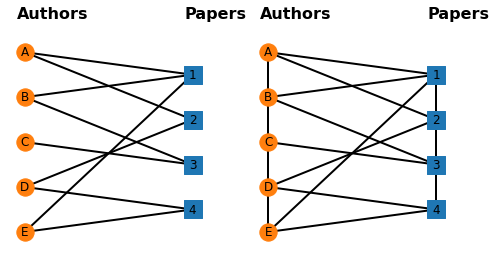

In [8]:
x = torch.vstack([torch.zeros((5, 1)), torch.ones((4, 1))])
edge_index = torch.tensor(
    [[0, 0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 6, 7, 7, 8, 8], [5, 6, 5, 7, 7, 6, 8, 5, 8, 0, 1, 4, 0, 3, 1, 2, 3, 4]],
    dtype=torch.long,
)
data = Data(x=x, edge_index=edge_index)
data_with_virtual_edges = connect_two_hop_neighbors(data)

plt.figure(figsize=(8, 4))

plt.subplot(121)
draw_bipartite(data)

plt.subplot(122)
draw_bipartite(data_with_virtual_edges)

## Add virtual nodes

In [9]:
def add_virtual_node(data: Data) -> Data:
    data = deepcopy(data)
    node_id = len(data.x)
    data.x = torch.vstack([data.x, torch.ones(1)])
    list1 = [node_id] * node_id
    list2 = list(range(node_id))
    data.edge_index = torch.hstack([data.edge_index, torch.tensor([list1 + list2, list2 + list1])])
    return data

In [10]:
def average_shortest_path_length(data: Data) -> float:
    G = to_networkx(data, to_undirected=data.is_undirected())
    return nx.average_shortest_path_length(G)

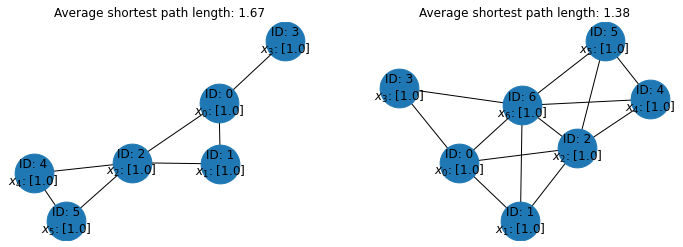

In [11]:
x = torch.ones((6, 1))
edge_index = torch.tensor(
    [[0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 5], [1, 2, 3, 0, 2, 0, 1, 4, 5, 0, 2, 5, 2, 4]], dtype=torch.long
)
data = Data(x=x, edge_index=edge_index)
data_with_virtual_node = add_virtual_node(data)

plt.figure(figsize=(12, 4))

ax1 = plt.subplot(121)
ax1.set_title(f"Average shortest path length: {average_shortest_path_length(data):.2f}")
draw_graph_from_data(data)

ax2 = plt.subplot(122)
ax2.set_title(f"Average shortest path length: {average_shortest_path_length(data_with_virtual_node):.2f}")
draw_graph_from_data(data_with_virtual_node)

# Node Neighborhood Sampling

> The following part is an adaptation of a [example](https://github.com/pyg-team/pytorch_geometric/blob/bee6ca2e78890e57c97f71b6110dc86cbdbf5efb/examples/reddit.py).

In [12]:
from torch_geometric.datasets import Reddit
from torch_geometric.loader import NeighborSampler
from torch_geometric.nn import SAGEConv

In [13]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int) -> None:
        super().__init__()

        self.num_layers = 2

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x: torch.Tensor, adjs: List[EdgeIndex]) -> torch.Tensor:
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[: size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1)

    def inference(self, x_all: torch.Tensor, subgraph_loader: NeighborSampler) -> torch.Tensor:
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description("Evaluating")

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[: size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all

In [14]:
class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        x: torch.Tensor,
        y: torch.Tensor,
        train_mask: torch.Tensor,
        val_mask: torch.Tensor,
        test_mask: torch.Tensor,
        optimizer: torch.optim.Optimizer,
        sizes: List[int] = [25, 10],
        batch_size: int = 1024,
        num_workers: int = 2,
    ) -> None:
        self.model = model
        self.data = data
        self.x = x
        self.y = y
        self.train_mask = train_mask
        self.val_mask = val_mask
        self.test_mask = test_mask
        self.optimizer = optimizer
        self.train_loader = NeighborSampler(
            data.edge_index,
            node_idx=data.train_mask,
            sizes=sizes,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
        )
        self.subgraph_loader = NeighborSampler(
            data.edge_index, node_idx=None, sizes=[-1], batch_size=batch_size, shuffle=False, num_workers=num_workers
        )

    def training_epoch(self, epoch: int) -> float:
        self.model.train()
        pbar = tqdm(total=int(self.train_mask.sum()))
        pbar.set_description(f"Epoch {epoch:02d}")
        total_loss = 0
        for batch_size, n_id, adjs in self.train_loader:
            # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
            adjs = [adj.to(device) for adj in adjs]
            self.optimizer.zero_grad()
            out = self.model(self.x[n_id], adjs)
            loss = F.nll_loss(out, self.y[n_id[:batch_size]])
            loss.backward()
            self.optimizer.step()
            total_loss += float(loss)
            pbar.update(batch_size)

        pbar.close()
        loss = total_loss / len(self.train_loader)
        return loss

    @torch.no_grad()
    def evaluate(self) -> List[float]:
        self.model.eval()

        out = self.model.inference(self.x, self.subgraph_loader)
        y_true = self.y.cpu().unsqueeze(-1)
        y_pred = out.argmax(dim=-1, keepdim=True)

        results = []
        for mask in [self.train_mask, self.val_mask, self.test_mask]:
            results += [int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]

        return results

    def fit(self, num_epochs: int = 10) -> None:
        for epoch in range(1, num_epochs + 1):
            loss = self.training_epoch(epoch)
            print(f"Epoch {epoch:02d}, Loss: {loss:.4f}")
            train_acc, val_acc, test_acc = self.evaluate()
            print(f"Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")

In [15]:
path = os.path.join("..", "tmp", "data", "Reddit")
dataset = Reddit(path)
data = dataset[0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SAGE(dataset.num_features, 256, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainer = Trainer(
    model=model.to(device),
    x=data.x.to(device),
    y=data.y.squeeze().to(device),
    train_mask=data.train_mask,
    val_mask=data.val_mask,
    test_mask=data.test_mask,
    optimizer=optimizer,
)
trainer.fit(num_epochs=5)

torch.cuda.empty_cache()

Epoch 01: 100%|██████████| 153431/153431 [00:06<00:00, 25072.95it/s]


Epoch 01, Loss: 0.5092


Evaluating: 100%|██████████| 465930/465930 [00:17<00:00, 27300.96it/s]


Train: 0.9511, Val: 0.9501, Test: 0.9492


Epoch 02: 100%|██████████| 153431/153431 [00:05<00:00, 25749.95it/s]


Epoch 02, Loss: 0.4482


Evaluating: 100%|██████████| 465930/465930 [00:16<00:00, 27571.75it/s]


Train: 0.9535, Val: 0.9504, Test: 0.9488


Epoch 03: 100%|██████████| 153431/153431 [00:05<00:00, 25820.46it/s]


Epoch 03, Loss: 0.5144


Evaluating: 100%|██████████| 465930/465930 [00:17<00:00, 27162.28it/s]


Train: 0.9546, Val: 0.9486, Test: 0.9483


Epoch 04: 100%|██████████| 153431/153431 [00:05<00:00, 26134.48it/s]


Epoch 04, Loss: 0.5577


Evaluating: 100%|██████████| 465930/465930 [00:15<00:00, 29993.98it/s]


Train: 0.9580, Val: 0.9519, Test: 0.9505


Epoch 05: 100%|██████████| 153431/153431 [00:05<00:00, 25951.81it/s]


Epoch 05, Loss: 0.5594


Evaluating: 100%|██████████| 465930/465930 [00:16<00:00, 27472.70it/s]

Train: 0.9554, Val: 0.9483, Test: 0.9471


# Prediction Heads: Node-level

> See previous example.

# Prediction Heads: Edge-level

> The following part is an adaptation of a PyTorch Geometric [example](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/link_pred.py).

In [16]:
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

In [17]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int, use_dot: bool = True) -> None:
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.use_dot = use_dot
        if not use_dot:
            self.linear = torch.nn.Linear(out_channels * 2, 1)

    def encode(self, x: torch.Tensor, edge_index) -> torch.Tensor:
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z: torch.Tensor, edge_label_index) -> torch.Tensor:
        if self.use_dot:
            return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
        else:
            z = torch.hstack([z[edge_label_index[0]], z[edge_label_index[1]]])
            return self.linear(z)

In [18]:
class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: Data,
        val_data: Data,
        test_data: Data,
        optimizer: torch.optim.Optimizer,
    ) -> None:
        self.model = model
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.optimizer = optimizer

    def training_epoch(self) -> torch.Tensor:
        self.model.train()
        self.optimizer.zero_grad()
        z = model.encode(self.train_data.x, self.train_data.edge_index)

        # We perform a new round of negative sampling for every training epoch:
        neg_edge_index = negative_sampling(
            edge_index=self.train_data.edge_index,
            num_nodes=self.train_data.num_nodes,
            num_neg_samples=self.train_data.edge_label_index.size(1),
            method="sparse",
        )

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([train_data.edge_label, train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = F.binary_cross_entropy_with_logits(out, edge_label)
        loss.backward()
        optimizer.step()
        return loss

    @torch.no_grad()
    def evaluate(self) -> List[float]:
        model.eval()
        results = []
        for data in [self.val_data, self.test_data]:
            z = model.encode(data.x, data.edge_index)
            out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
            auc = roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())
            results.append(auc)

        return results

    def fit(self, num_epochs: int = 100, print_interval: int = 1) -> None:
        for epoch in range(1, num_epochs + 1):
            loss = self.training_epoch()
            val_auc, test_auc = self.evaluate()
            if epoch % print_interval == 0:
                print(f"Epoch {epoch:02d}, Loss: {loss:.4f}")
                print(f"Val: {val_auc:.4f}, Test: {test_auc:.4f}")

## (1) Concatenation + Linear

In [19]:
USE_DOT = False


device = torch.device("cpu")
# See https://github.com/pyg-team/pytorch_geometric/issues/3641

transform = T.Compose(
    [
        T.NormalizeFeatures(),
        T.ToDevice(device),
        T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, add_negative_train_samples=False),
    ]
)

path = os.path.join("..", "tmp", "data", "Planetoid")
dataset = Planetoid(path, name="Cora", transform=transform)
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = dataset[0]

model = GCN(dataset.num_features, 128, 64, use_dot=USE_DOT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainer = Trainer(
    model=model.to(device),
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    optimizer=optimizer,
)
trainer.fit(print_interval=20)

Epoch 20, Loss: 0.5543
Val: 0.6901, Test: 0.7165
Epoch 40, Loss: 0.5124
Val: 0.6944, Test: 0.7244
Epoch 60, Loss: 0.4920
Val: 0.6918, Test: 0.7212
Epoch 80, Loss: 0.4940
Val: 0.6839, Test: 0.7149
Epoch 100, Loss: 0.4979
Val: 0.6793, Test: 0.7178


## (2) Dot product

In [20]:
USE_DOT = True


device = torch.device("cpu")
# See https://github.com/pyg-team/pytorch_geometric/issues/3641

transform = T.Compose(
    [
        T.NormalizeFeatures(),
        T.ToDevice(device),
        T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, add_negative_train_samples=False),
    ]
)

path = os.path.join("..", "tmp", "data", "Planetoid")
dataset = Planetoid(path, name="Cora", transform=transform)
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = dataset[0]

model = GCN(dataset.num_features, 128, 64, use_dot=USE_DOT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainer = Trainer(
    model=model.to(device),
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    optimizer=optimizer,
)
trainer.fit(print_interval=20)

Epoch 20, Loss: 0.6386
Val: 0.6856, Test: 0.7165
Epoch 40, Loss: 0.4946
Val: 0.8346, Test: 0.8321
Epoch 60, Loss: 0.4658
Val: 0.8945, Test: 0.8978
Epoch 80, Loss: 0.4544
Val: 0.9053, Test: 0.9068
Epoch 100, Loss: 0.4460
Val: 0.9144, Test: 0.9131


# Prediction Heads: Graph-level

## (1) Global mean pooling

In [21]:
# TODO

## (2) Global max pooling

In [22]:
# TODO

## (3) Global sum pooling

In [23]:
# TODO

# Hierarchical Global Pooling

In [24]:
# TODO